# Comparing Rates

### Requirements:
1. `numpy`
2. `statsmodels`
3. `matplotlib`
4. `scipy`

In [19]:
import numpy as np

import statsmodels
import statsmodels.api

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

import scipy
import scipy.stats

In [2]:
import numpy as np

rng = np.random.default_rng(seed=520610)


def produce_samples_from_rate(rate: float, n: int) -> np.ndarray:
    samples = np.array(
        [0] * int(np.round((1 - rate) * n)) + [1] * int(np.round(rate * n))
    )
    rng.shuffle(samples)

    return samples


rate_1 = 0.7
samples_1 = produce_samples_from_rate(rate=rate_1, n=10)

rate_2 = 0.8
samples_2 = produce_samples_from_rate(rate=rate_2, n=10)

In [3]:
print(rate_1, samples_1)
print(rate_2, samples_2)

0.7 [1 1 1 0 1 1 0 1 0 1]
0.8 [1 1 0 1 1 1 0 1 1 1]


## Frequentist Treatment

### Measures for Rate Differences

In [4]:
def risk_difference(rate_a: float, rate_b: float) -> float:
    return rate_b - rate_a


def number_need_to_treat(rate_a: float, rate_b: float) -> float:
    return 1 / (rate_b - rate_a)


def relative_risk(rate_a: float, rate_b: float) -> float:
    return rate_b / rate_a


def relative_risk_reduction(rate_a: float, rate_b: float) -> float:
    return 1 - (rate_b / rate_a)


def relative_risk_increase(rate_a: float, rate_b: float) -> float:
    return (rate_b / rate_a) - 1

/tmp/ipykernel_31559/1705594271.py:6: RuntimeWarning: divide by zero encountered in divide
  return 1 / (rate_b - rate_a)


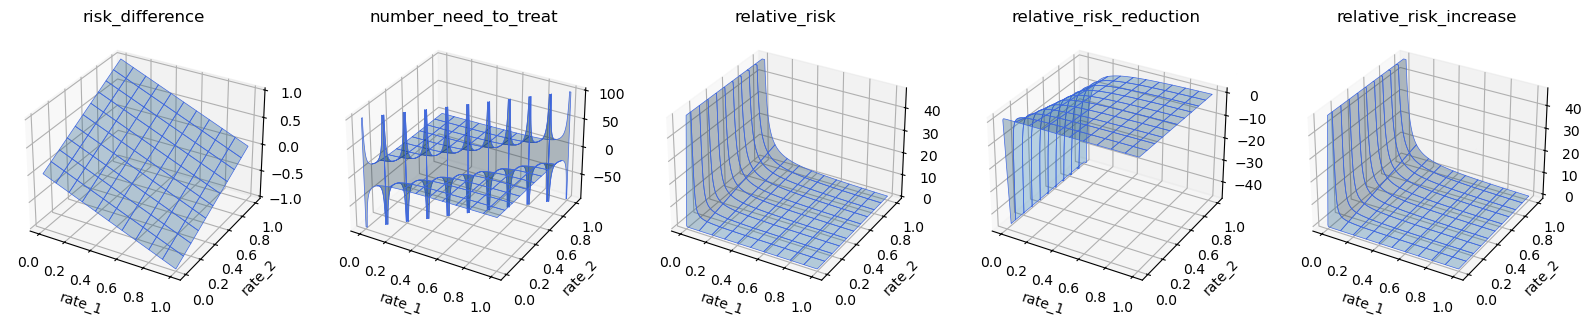

In [5]:
rates_a = np.linspace(0.0 + 1e-3, 1.0 - 1e-3, num=1000)
rates_b = np.linspace(0.0 + 1e-3, 1.0 - 1e-3, num=1000)

rates_a_mesh, rates_b_mesh = np.meshgrid(rates_a, rates_b)

fig = plt.figure(figsize=(20, 5))


def plot_metric_vals_3d(pos, metric_vals, title: str = "", clip: bool = False):
    if clip:
        extrema = np.quantile(metric_vals, [0.01, 0.99])
        metric_vals = np.clip(metric_vals, *extrema)

    ax = fig.add_subplot(*pos, projection="3d")

    ax.plot_surface(
        rates_a_mesh,
        rates_b_mesh,
        metric_vals,
        edgecolor="royalblue",
        lw=0.5,
        rstride=100,
        cstride=100,
        alpha=0.3,
    )

    ax.set_xlabel("rate_1")
    ax.set_ylabel("rate_2")

    ax.set_title(title)


plot_metric_vals_3d(
    (1, 5, 1),
    risk_difference(rates_a_mesh, rates_b_mesh),
    title="risk_difference",
    clip=False,
)
plot_metric_vals_3d(
    (1, 5, 2),
    number_need_to_treat(rates_a_mesh, rates_b_mesh),
    title="number_need_to_treat",
    clip=True,
)
plot_metric_vals_3d(
    (1, 5, 3),
    relative_risk(rates_a_mesh, rates_b_mesh),
    title="relative_risk",
    clip=True,
)
plot_metric_vals_3d(
    (1, 5, 4),
    relative_risk_reduction(rates_a_mesh, rates_b_mesh),
    title="relative_risk_reduction",
    clip=True,
)
plot_metric_vals_3d(
    (1, 5, 5),
    relative_risk_increase(rates_a_mesh, rates_b_mesh),
    title="relative_risk_increase",
    clip=True,
)


### The Problem with Rate Differences

In [6]:
print(f"Rates ratio: {rate_1 / rate_2:.4f}")
print(f"Complementary rates ratio: {(1 - rate_1) / (1 - rate_2):.4f}")

Rates ratio: 0.8750
Complementary rates ratio: 1.5000


### Odds

In [7]:
def odds(rate: float) -> float:
    return rate / (1 - rate)


def odds_ratio(rate_a: float, rate_b: float) -> float:
    return odds(rate_b) / odds(rate_a)


def log_odds_ratio(rate_a: float, rate_b: float) -> float:
    return np.log(odds(rate_b)) - np.log(odds(rate_a))


In [8]:
print(f"Odds ratio: {odds_ratio(rate_1, rate_2):.4f}")
print(f"Complementary odds ratio: {odds_ratio(1-rate_1, 1-rate_2):.4f}")

Odds ratio: 1.7143
Complementary odds ratio: 0.5833


In [9]:
np.allclose(odds_ratio(rate_1, rate_2), 1 / odds_ratio(1 - rate_1, 1 - rate_2))

True

In [10]:
print(f"Log-odds ratio: {log_odds_ratio(rate_1, rate_2):.4f}")
print(f"Complementary log-odds ratio: {log_odds_ratio(1-rate_1, 1-rate_2):.4f}")

Log-odds ratio: 0.5390
Complementary log-odds ratio: -0.5390


### The log-odds ratio is asymptotically normally distributed

In [11]:
def sample_rates(n: int, p: float, size: int) -> np.ndarray:
    num_hits = rng.binomial(n=n, p=p, size=size)
    rates = num_hits / n

    return rates

/tmp/ipykernel_31559/2911438240.py:2: RuntimeWarning: divide by zero encountered in divide
  return rate / (1 - rate)
/tmp/ipykernel_31559/2911438240.py:6: RuntimeWarning: invalid value encountered in divide
  return odds(rate_b) / odds(rate_a)
/tmp/ipykernel_31559/2911438240.py:10: RuntimeWarning: invalid value encountered in subtract
  return np.log(odds(rate_b)) - np.log(odds(rate_a))


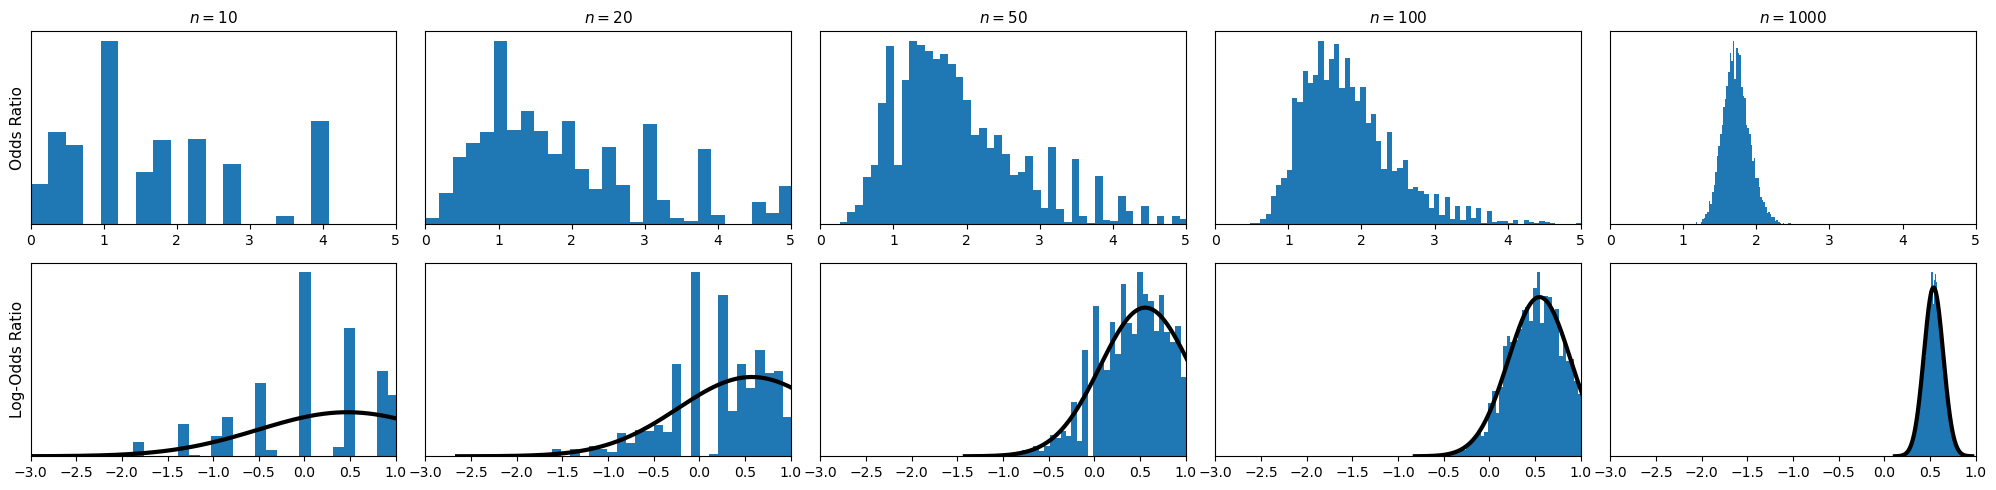

In [12]:
fig, axes = plt.subplots(2, 5, figsize=(20, 5))

for col_num, n in enumerate([10, 20, 50, 100, 1000]):
    rate_1_samples = sample_rates(n=n, p=rate_1, size=10000)
    rate_2_samples = sample_rates(n=n, p=rate_2, size=10000)

    # Plot odds ratio ==========================================================
    sampled_odds_ratio = odds_ratio(rate_1_samples, rate_2_samples)
    sampled_odds_ratio = sampled_odds_ratio[np.isfinite(sampled_odds_ratio)]

    axes[0, col_num].hist(sampled_odds_ratio, bins="auto", density=True)

    sampled_log_odds_ratio = log_odds_ratio(rate_1_samples, rate_2_samples)
    sampled_log_odds_ratio = sampled_log_odds_ratio[np.isfinite(sampled_log_odds_ratio)]

    axes[0, col_num].set_xlim(0, 5)

    # Plot log-odds ratio ======================================================
    axes[1, col_num].hist(sampled_log_odds_ratio, bins="auto", density=True, alpha=1.0)

    mu = np.mean(sampled_log_odds_ratio)
    sigma = np.std(sampled_log_odds_ratio)
    x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
    axes[1, col_num].plot(x, scipy.stats.norm.pdf(x, mu, sigma), c="black", lw=3)

    axes[1, col_num].set_xlim(-3, 1)

    # Misc. ====================================================================
    axes[0, col_num].set_yticks([])
    axes[1, col_num].set_yticks([])

    axes[0, col_num].set_title(f"$n={n}$", fontsize=11)

    if col_num == 0:
        axes[0, col_num].set_ylabel("Odds Ratio", fontsize=11)
        axes[1, col_num].set_ylabel("Log-Odds Ratio", fontsize=11)


fig.tight_layout()

### The $z$-test

/tmp/ipykernel_31559/2911438240.py:2: RuntimeWarning: divide by zero encountered in divide
  return rate / (1 - rate)
/tmp/ipykernel_31559/2911438240.py:10: RuntimeWarning: divide by zero encountered in log
  return np.log(odds(rate_b)) - np.log(odds(rate_a))
/tmp/ipykernel_31559/2911438240.py:10: RuntimeWarning: invalid value encountered in subtract
  return np.log(odds(rate_b)) - np.log(odds(rate_a))


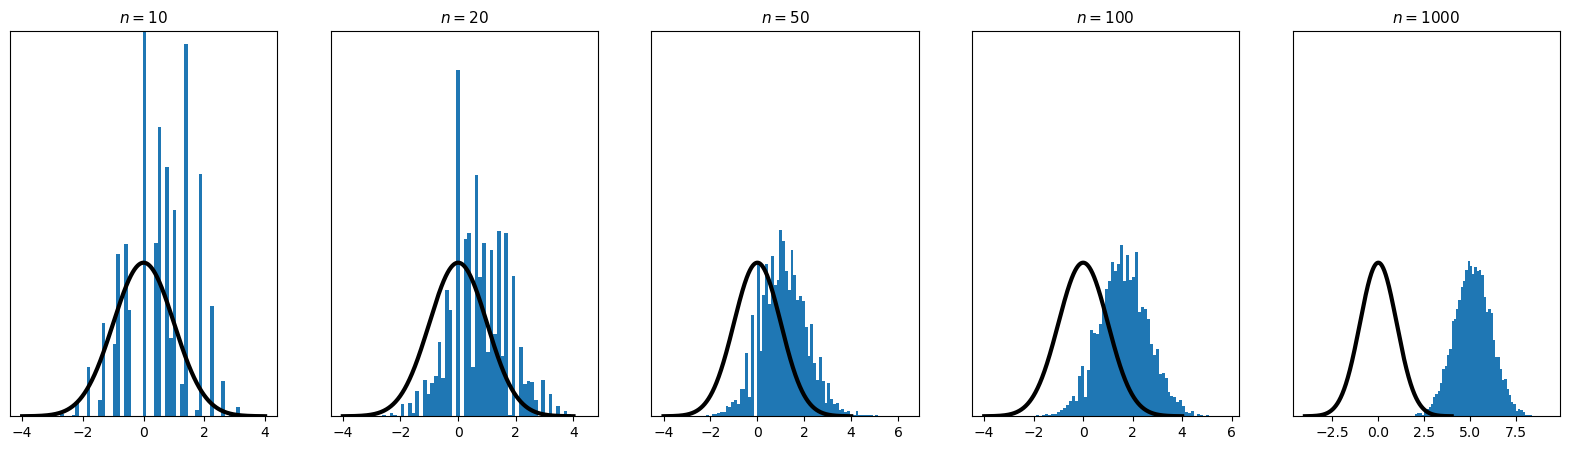

In [13]:
H = 0.0

fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

for col_num, n in enumerate([10, 20, 50, 100, 1000]):
    rate_1_samples = sample_rates(n=n, p=rate_1, size=10000)
    rate_2_samples = sample_rates(n=n, p=rate_2, size=10000)

    sampled_log_odds_ratio = log_odds_ratio(rate_1_samples, rate_2_samples)
    sampled_log_odds_ratio = sampled_log_odds_ratio[np.isfinite(sampled_log_odds_ratio)]

    effect_size_distribution = (sampled_log_odds_ratio - H) / np.std(
        sampled_log_odds_ratio
    )

    axes[col_num].hist(effect_size_distribution, bins="auto", density=True, alpha=1.0)

    x = np.linspace(-4, 4, 1000)
    axes[col_num].plot(x, scipy.stats.norm.pdf(x, 0.0, 1.0), c="black", lw=3)

    axes[col_num].set_ylim(0, 1)
    axes[col_num].set_yticks([])
    axes[col_num].set_yticks([])

    axes[col_num].set_title(f"$n={n}$", fontsize=11)

In [14]:
def z_test(
    rate_a: float, rate_b: float, n: int, alpha: float = 0.95, H: float = 0.0
) -> float:
    z_critical = scipy.stats.norm.ppf((1 - alpha) / 2)

    mean = log_odds_ratio(rate_a, rate_b)

    se = np.sqrt(
        1 / (rate_a * n)
        + 1 / (n - rate_a * n)
        + 1 / (rate_b * n)
        + 1 / (n - rate_b * n)
    )

    ci_lb = mean - np.abs(z_critical) * se
    ci_ub = mean + np.abs(z_critical) * se

    mean_effect_size = (mean - H) / se

    p_value = scipy.stats.norm.cdf(mean_effect_size)

    significant = False
    if p_value <= 1 - alpha:
        significant = True

    result = f"The difference between experiment 1 (rate={rate_a:.2f}, n={n}) and experiment 2 (rate={rate_b:.2f}, n={n}) {'is' if significant else 'is not'}\nsignificant at the {alpha*100:.0f}% confidence level (log odds-ratio={mean:.4f} [{ci_lb:.4f}, {ci_ub:.4f}], z={mean_effect_size:.4f}, p={p_value:.4f}])."

    return result


In [15]:
print(z_test(rate_1, rate_2, n=10, alpha=0.95, H=0))

The difference between experiment 1 (rate=0.70, n=10) and experiment 2 (rate=0.80, n=10) is not
significant at the 95% confidence level (log odds-ratio=0.5390 [-1.5177, 2.5957], z=0.5136, p=0.6962]).


In [16]:
print(z_test(rate_1, rate_2, n=100, alpha=0.95, H=0))

The difference between experiment 1 (rate=0.70, n=100) and experiment 2 (rate=0.80, n=100) is not
significant at the 95% confidence level (log odds-ratio=0.5390 [-0.1114, 1.1894], z=1.6243, p=0.9478]).


In [17]:
print(z_test(rate_1, rate_2, n=1000, alpha=0.95, H=0))

The difference between experiment 1 (rate=0.70, n=1000) and experiment 2 (rate=0.80, n=1000) is not
significant at the 95% confidence level (log odds-ratio=0.5390 [0.3333, 0.7447], z=5.1364, p=1.0000]).


## Logistic Regression

In [20]:
dependent = np.concatenate([samples_1, samples_2])

independent = np.stack(
    [
        np.concatenate(
            [np.ones(shape=samples_1.shape), np.ones(shape=samples_2.shape)]
        ),
        np.concatenate(
            [np.zeros(shape=samples_1.shape), np.ones(shape=samples_2.shape)]
        ),
    ],
    axis=1,
)

log_reg = statsmodels.api.Logit(
    endog=dependent,
    exog=independent,
).fit()

print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.555633
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   20
Model:                          Logit   Df Residuals:                       18
Method:                           MLE   Df Model:                            1
Date:                Thu, 19 Sep 2024   Pseudo R-squ.:                 0.01192
Time:                        12:23:15   Log-Likelihood:                -11.113
converged:                       True   LL-Null:                       -11.247
Covariance Type:            nonrobust   LLR p-value:                    0.6046
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8473      0.690      1.228      0.220      -0.505       2.200
x1             0.5390      1.

In [26]:
1 / (1 + np.exp(-0.8473))

0.700000449318495

In [27]:
1 / (1 + np.exp(-0.8473 + -0.5390))


0.8000009022192913

## Bayesian Treatment

### Independent Samples

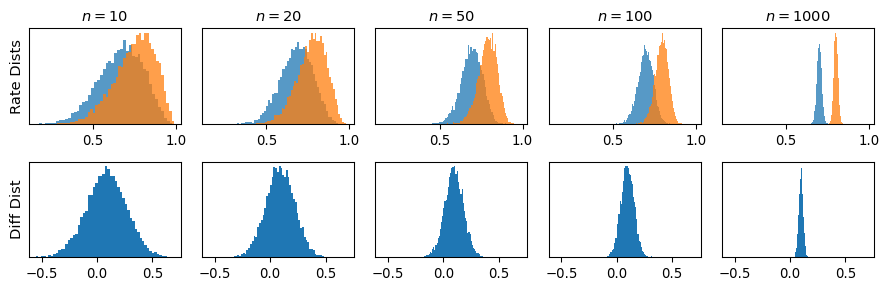

In [30]:
H = 0.0

fig, axes = plt.subplots(2, 5, figsize=(900/96, 300/96), dpi=96, sharex="row", sharey=False)

for col_num, n in enumerate([10, 20, 50, 100, 1000]):
    num_losses_1, num_wins_1 = np.bincount(produce_samples_from_rate(rate=rate_1, n=n))

    experiment_1_samples = np.random.beta(
        a=1 + num_wins_1, b=1 + num_losses_1, size=10000
    )

    axes[0, col_num].hist(experiment_1_samples, bins="auto", density=True, alpha=0.75)

    num_losses_2, num_wins_2 = np.bincount(produce_samples_from_rate(rate=rate_2, n=n))

    experiment_2_samples = np.random.beta(
        a=1 + num_wins_2, b=1 + num_losses_2, size=10000
    )

    axes[0, col_num].hist(experiment_2_samples, bins="auto", density=True, alpha=0.75)

    axes[0, col_num].set_yticks([])

    axes[0, col_num].set_title(f"$n={n}$", fontsize=11)

    axes[1, col_num].hist(
        experiment_2_samples - experiment_1_samples,
        bins="auto",
        density=True,
        alpha=1.0,
    )

    axes[1, col_num].set_yticks([])

    if col_num == 0:
        axes[0, col_num].set_ylabel("Rate Dists", fontsize=11)
        axes[1, col_num].set_ylabel("Diff Dist", fontsize=11)

fig.tight_layout()


In [31]:
fig.savefig("./figures/two_betas_and_diff_dist.svg", transparent=True)

In [21]:
def bayesian_compare_rates_independent(
    samples_a: np.ndarray, samples_b: np.ndarray, ci_prob: float = 0.95
) -> str:
    num_losses_a, num_wins_a = np.bincount(samples_a)
    num_losses_b, num_wins_b = np.bincount(samples_b)

    experiment_1_samples = np.random.beta(
        a=1 + num_wins_a, b=1 + num_losses_a, size=10000
    )

    experiment_2_samples = np.random.beta(
        a=1 + num_wins_b, b=1 + num_losses_b, size=10000
    )

    diff_dist = experiment_2_samples - experiment_1_samples

    median_diff = np.median(diff_dist)
    hdi = np.quantile(diff_dist, [(1 - ci_prob) / 2, 1 - ((1 - ci_prob) / 2)])

    p_direction = np.mean(experiment_2_samples > experiment_1_samples)

    n_a = num_wins_a + num_losses_a
    rate_a = num_wins_a / n_a

    n_b = num_wins_b + num_losses_b
    rate_b = num_wins_b / n_b

    result = f"Experiment 2 (rate={rate_b:.2f}, n={n_b}) being greater than experiment 1 (rate={rate_a:.2f}, n={n_a}) is {p_direction*100:.2f}% probable (median={median_diff:.4f} [{hdi[0]:.4f}, {hdi[1]:.4f}])"

    return result


In [22]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=10)
samples_2 = produce_samples_from_rate(rate=rate_2, n=10)

print(bayesian_compare_rates_independent(samples_1, samples_2))

Experiment 2 (rate=0.80, n=10) being greater than experiment 1 (rate=0.70, n=10) is 68.85% probable (median=0.0866 [-0.2606, 0.4289])


In [23]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=100)
samples_2 = produce_samples_from_rate(rate=rate_2, n=100)

print(bayesian_compare_rates_independent(samples_1, samples_2))


Experiment 2 (rate=0.80, n=100) being greater than experiment 1 (rate=0.70, n=100) is 95.02% probable (median=0.0974 [-0.0184, 0.2179])


In [24]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=1000)
samples_2 = produce_samples_from_rate(rate=rate_2, n=1000)

print(bayesian_compare_rates_independent(samples_1, samples_2))


Experiment 2 (rate=0.80, n=1000) being greater than experiment 1 (rate=0.70, n=1000) is 100.00% probable (median=0.1003 [0.0615, 0.1373])


### Dependent Samples

In [25]:
def bayesian_compare_rates_dependent(
    samples_a: np.ndarray, samples_b: np.ndarray
) -> str:
    paired_samples = np.stack([samples_a, samples_b], axis=1)

    combinations, counts = np.unique(paired_samples, axis=0, return_counts=True)

    identical_idx = np.where(
        ((combinations[:, 0] == 0) & (combinations[:, 1] == 0))
        | ((combinations[:, 0] == 1) & (combinations[:, 1] == 1))
    )

    wins_a_idx = np.where((combinations[:, 0] == 1) & (combinations[:, 1] == 0))

    wins_b_idx = np.where((combinations[:, 0] == 0) & (combinations[:, 1] == 1))

    num_ties = np.sum(counts[identical_idx])
    num_wins_a = counts[wins_a_idx].squeeze()
    num_wins_b = counts[wins_b_idx].squeeze()

    params = np.array([num_wins_a + 1, num_wins_b + 1, num_ties + 1])

    map_win_rate_a = (params[0] - 1) / (np.sum(params) - 3)
    map_win_rate_b = (params[1] - 1) / (np.sum(params) - 3)

    dirichlet_samples = rng.dirichlet(params, size=10000)

    prob_b_greater = np.mean(dirichlet_samples[:, 1] > dirichlet_samples[:, 0])

    rate_a = np.mean(samples_1)
    rate_b = np.mean(samples_2)
    n = paired_samples.shape[0]

    result = f"Experiment 2 (rate={rate_b:.2f}, n={n}) being greater than experiment 1 (rate={rate_a:.2f}, n={n}) is {prob_b_greater*100:.2f}% probable.\nOn average, experiment 1 beat experiment 2 {map_win_rate_a*100:.2f}% of times, and experiment 2 beat experiment 1 {map_win_rate_b*100:.2f}% of times."

    return result

In [26]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=10)
samples_2 = produce_samples_from_rate(rate=rate_2, n=10)

print(bayesian_compare_rates_dependent(samples_1, samples_2))

Experiment 2 (rate=0.80, n=10) being greater than experiment 1 (rate=0.70, n=10) is 66.44% probable.
On average, experiment 1 beat experiment 2 20.00% of times, and experiment 2 beat experiment 1 30.00% of times.


In [27]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=100)
samples_2 = produce_samples_from_rate(rate=rate_2, n=100)

print(bayesian_compare_rates_dependent(samples_1, samples_2))


Experiment 2 (rate=0.80, n=100) being greater than experiment 1 (rate=0.70, n=100) is 93.98% probable.
On average, experiment 1 beat experiment 2 15.00% of times, and experiment 2 beat experiment 1 25.00% of times.


In [28]:
samples_1 = produce_samples_from_rate(rate=rate_1, n=1000)
samples_2 = produce_samples_from_rate(rate=rate_2, n=1000)

print(bayesian_compare_rates_dependent(samples_1, samples_2))


Experiment 2 (rate=0.80, n=1000) being greater than experiment 1 (rate=0.70, n=1000) is 100.00% probable.
On average, experiment 1 beat experiment 2 14.10% of times, and experiment 2 beat experiment 1 24.10% of times.


## Area Under the Improvement Curve

In [29]:
import statsmodels.nonparametric
import statsmodels.nonparametric.kernel_regression


In [ ]:
log_odds_ratio()

In [129]:
samples_1 = rng.beta(a=8, b=4, size=10000)

samples_2 = odds(samples_1) * rng.gamma(shape=5, scale=0.5, size=10000)
samples_2 = samples_2 / (1 + samples_2)

In [130]:
log_odds_ratio_array = log_odds_ratio(samples_1, samples_2)

np.exp(np.mean(log_odds_ratio_array))

2.2531397545475467

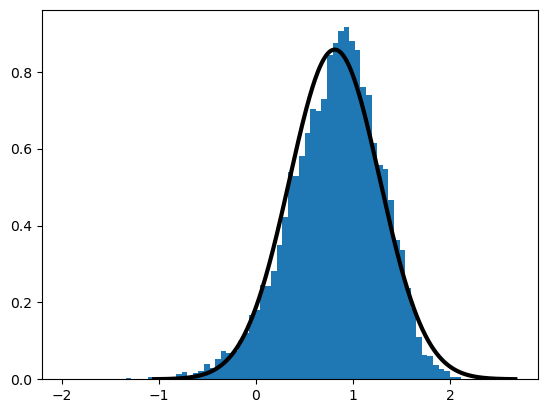

In [131]:
plt.hist(
    log_odds_ratio_array,
    bins="auto",
    density=True,
);

mu = np.mean(log_odds_ratio_array)
sigma = np.std(log_odds_ratio_array)
x = np.linspace(mu - 4 * sigma, mu + 4 * sigma, 1000)
plt.plot(x, scipy.stats.norm.pdf(x, mu, sigma), c="black", lw=3)

In [132]:
np.exp(np.median(log_odds_ratio_array))

2.3341650281301534

In [133]:
predictions, _ = statsmodels.nonparametric.kernel_regression.KernelReg(
    endog=np.concatenate([[0], samples_2, [1]]),
    exog=np.concatenate([[0], samples_1, [1]]),
    var_type="c",
).fit(samples_1)

In [134]:
sort_idx = np.argsort(samples_1)

sorted_samples_1 = samples_1[sort_idx]
sorted_samples_2 = samples_2[sort_idx]
sorted_predictions = predictions[sort_idx]

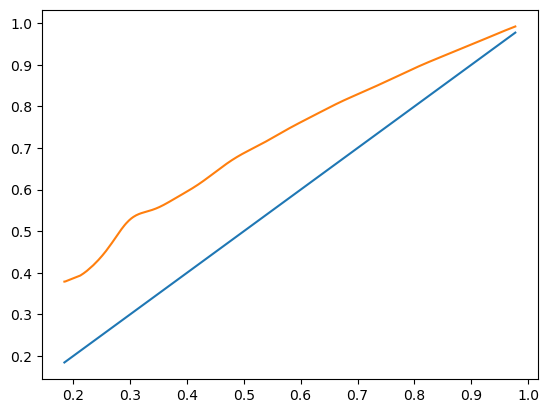

In [135]:
plt.plot(sorted_samples_1, sorted_samples_1)
plt.plot(sorted_samples_1, sorted_predictions)

In [136]:
no_improvement_area = (
    0.5 * sorted_samples_1[-1] * (sorted_samples_1[-1] - sorted_samples_1[0])
)


In [137]:
no_improvement_area

0.3874471581806667

In [138]:
import scipy.integrate


area = scipy.integrate.simpson(y=sorted_predictions, x=sorted_samples_1)

In [140]:
area


0.57606513272238

In [139]:
2 * (area / (2 * no_improvement_area)) - 1

0.48682244935646346